In [1]:

import glob

from preprocess_audio import preprocess_audio
from seperate_channels import seperate_channels
#from csv_to_nemo_dicts import csv_to_nemo_dicts

from ASR import ASR
from VAD import VAD
from CTC import CTC
from diarization import diarization

from align_words_with_speakers import align_words_with_speakers

import glob
import os
from contextlib import contextmanager
import torch
import torchaudio
import pandas as pd

# Check device compatibility
if torch.backends.mps.is_available():
    print("MPS is still not compatible switching to cpu")
    device = torch.device("cpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA is available. Using CPU.")
print(f"Using device: {device}")


@contextmanager
def load_vad_model():
    vad_model = VAD(sample_rate=16000)
    yield vad_model
    vad_model.empty_cache()  # Clear GPU memory

@contextmanager
def load_ctc_model():
    ctc_model = CTC(device)
    yield ctc_model
    ctc_model.empty_cache()  # Clear GPU memory

@contextmanager
def init_asr():
    asr_class = ASR()
    yield asr_class

@contextmanager
def load_diarization_model():
    diarization_model = diarization(device)
    yield diarization_model
    diarization_model.empty_cache()  # Clear GPU memory

import configparser

config = configparser.ConfigParser()
config.read('config.ini')


files = glob.glob(os.path.join(config['PATHS']['data'], '*.wav'))

# Input is stereo

# Step 1: create VAD references
for stereo_path in files:
    
    waveform, sample_rate = torchaudio.load(stereo_path)
    # Check if stereo
    if waveform.ndim == 2 and waveform.size(0) == 2:
        client_audio_path, agent_audio_path = seperate_channels(stereo_path)

        # Load audio file
        cient_waveform, sample_rate = torchaudio.load(client_audio_path)
        agent_waveform, sample_rate = torchaudio.load(agent_audio_path)

        with load_vad_model() as vad_model:
            client_timestamps, only_speech_client = vad_model.process(cient_waveform)
            agent_timestamps, only_speech_agent = vad_model.process(agent_waveform)
        
        oracle_rttm_path = vad_model.save_rttm(stereo_path, client_timestamps, agent_timestamps, saved_dir='oracle_rttm')
    else: #Mono
        pass

# Step 2: Audio 
for stereo_path in files:

    mono_path = preprocess_audio(stereo_path, saved_dir='audio_mono')
    # Load audio file
    mono_waveform, sample_rate = torchaudio.load(mono_path)

    # Step 1.1: VAD processing
    with load_vad_model() as vad_model:
        timestamps, speech = vad_model.process(mono_waveform)
        only_speech_path = vad_model.save_audio(mono_path, speech, saved_dir='speech_only')

    # Step 1.2: Transcribe from VAD
    with init_asr() as ASR_class:
        trs = ASR_class.process(only_speech_path)
        ASR_class.save(mono_path, trs, saved_dir='auto_trs')

    # Step 1.3: Word Alignment with CTC
    
    with load_ctc_model() as CTC_model:
        alignments = CTC_model.process(mono_waveform, trs, language='fre')
        words_csv_path = CTC_model.save(mono_path, alignments, saved_dir='auto_trs_aligned')

    #word_hyp, word_ts_hyp = csv_to_nemo_dicts([csv_file])

    #Ponctuation: in progress
    
    #Step diarization
    with load_diarization_model() as diarization_model:
        diarization = diarization_model.process(mono_path, mono_waveform)
        rttm_file_path = diarization_model.save_rttm(mono_path, diarization, saved_dir='rttm')

    words_speakers_csv_path = align_words_with_speakers(words_csv_path, rttm_file_path, mono_path, saved_dir='auto_trs_aligned_speakers')
    words_speakers_csv_path_oracle = align_words_with_speakers(words_csv_path, oracle_rttm_path, mono_path, saved_dir='auto_trs_aligned_speakers_oracle')

    #Step classify speakers
    
    df = pd.read_csv(words_speakers_csv_path)
    df_oracle = pd.read_csv(words_speakers_csv_path_oracle)

    # Group words by speaker
    trs_per_speaker = df.groupby("speaker")["word"].apply(lambda words: " ".join(words)).reset_index()
    trs_per_speaker_oracle = df_oracle.groupby("speaker")["word"].apply(lambda words: " ".join(words)).reset_index()

    print("Preds:")
    for speaker, trs in trs_per_speaker.values:
        print(f"Speaker {speaker}: {trs}")
    print()
    print('Oracle:')
    for speaker, trs in trs_per_speaker_oracle.values:
        
        print(f"Speaker {speaker}: {trs}")



MPS is still not compatible switching to cpu
Using device: cpu
Detected language: fr
punctuation not yet implemented


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:datasets:PyTorch version 2.5.1 available.
[NeMo W 2025-01-08 18:04:53 nemo_logging:361] /Users/research-team/miniconda3/envs/pytorch/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
      std = sequences.std(dim=-1, correction=1)
    


Preds:
Speaker SPEAKER_00: oui cest daccord pourriezvous tout dabord me renseigner votre numero de carte sil vous plait je vais faire la verification votre carte
Speaker SPEAKER_01: sa nous navons trouve aucune information de contact liee a votre carte cest le message qui apparait
Speaker SPEAKER_02: oui attendez du coup on va chercher la carte on a tout prevu sauf sa prenez

Oracle:
Speaker Unknown: oui
Speaker agent: oui cest daccord pourriezvous tout dabord me renseigner votre numero de carte sil vous plait je vais faire la verification prenez votre carte
Speaker client: sa nous navons trouve aucune information de contact liee a votre carte cest le message qui apparait attendez du coup on va chercher la carte on a tout prevu sauf sa


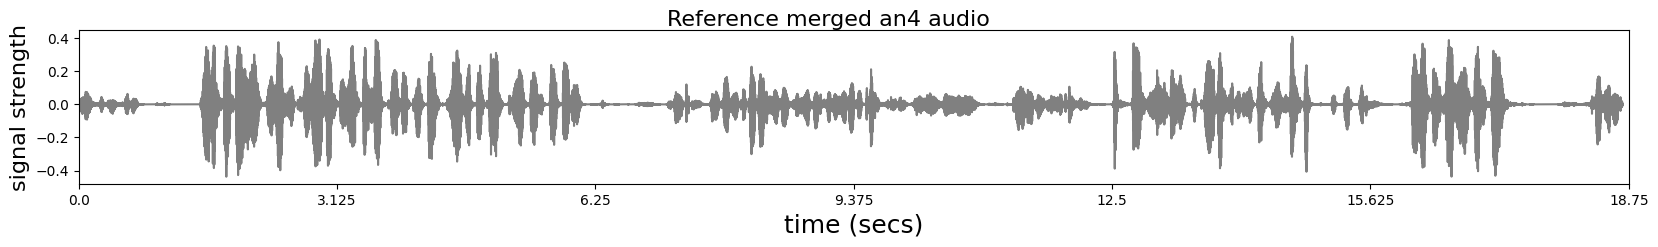

In [4]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(mono_path, sr=sr) 

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);

IPython.display.Audio(mono_path)